# Assembling detector data into images

The X-ray detectors at XFEL are made up of a number of small pieces. To get an image from the data, or analyse it spatially, we need to know where each piece is located.

This example reassembles some commissioning data from LPD, a detector which has 4 quadrants, 16 modules, and 256 tiles.
Elements (especially the quadrants) can be repositioned; talk to the detector group to ensure that you have the right
geometry information for your data.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py

from karabo_data import RunDirectory, stack_detector_data
from karabo_data.geometry import LPDGeometry

In [2]:
run = RunDirectory('/gpfs/exfel/exp/FXE/201830/p900020/proc/r0221/')
run.info()

# of trains:    513
Duration:       0:00:51.200000
First train ID: 54861753
Last train ID:  54862265

14 detector modules (LPD)
  e.g. module LPD00 : 256 x 256 pixels
  128 frames per train, 39040.0 total frames

0 instrument devices (excluding detectors):

0 control devices:



In [3]:
# Find a train with some data in
empty = np.asarray([])
for tid, train_data in run.trains():
    module_imgs = sum(d.get('image.data', empty).shape[0] for d in train_data.values())
    if module_imgs:
        print(tid, module_imgs)
        break

54861797 1792


In [4]:
tid, train_data = run.train_from_id(54861800)
print(tid)
for dev in sorted(train_data.keys()):
    print(dev, end='\t')
    try:
        print(train_data[dev]['image.data'].shape)
    except KeyError:
        print("No image.data")

54861800
FXE_DET_LPD1M-1/DET/0CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/10CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/11CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/12CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/13CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/14CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/15CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/1CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/2CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/3CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/4CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/6CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/8CH0:xtdf	(128, 256, 256)
FXE_DET_LPD1M-1/DET/9CH0:xtdf	(128, 256, 256)


Extract the detector images into a single Numpy array:

In [5]:
modules_data = stack_detector_data(train_data, 'image.data')
modules_data.shape

(128, 16, 256, 256)

To show the images, we sometimes need to 'clip' extreme high and low values, otherwise the colour map makes everything else the same colour.

In [6]:
def clip(array, min=-10000, max=10000):
    x = array.copy()
    finite = np.isfinite(x)
    # Suppress warnings comparing numbers to nan
    with np.errstate(invalid='ignore'):
        x[finite & (x < min)] = np.nan
        x[finite & (x > max)] = np.nan
    return x

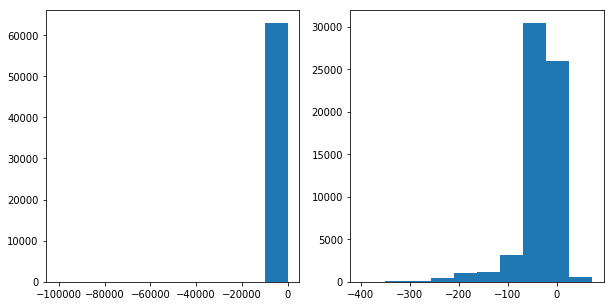

In [7]:
plt.figure(figsize=(10, 5))

a = modules_data[5][2]
plt.subplot(1, 2, 1).hist(a[np.isfinite(a)])

a = clip(a, min=-400, max=400)
plt.subplot(1, 2, 2).hist(a[np.isfinite(a)]);

Let's look at the iamge from a single module. You can see where it's divided up into tiles:

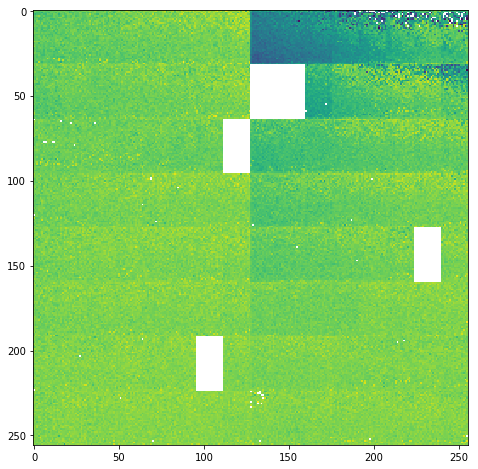

In [8]:
from karabo_data.geometry import splitChannelDataIntoTiles
plt.figure(figsize=(8, 8))
clipped_mod = clip(modules_data[5][2], -400, 500)
plt.imshow(clipped_mod)

Here's a single tile:

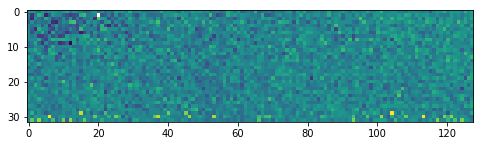

In [9]:
splitted = splitChannelDataIntoTiles(modules_data[:, 2])
splitted.shape
plt.figure(figsize=(8, 8))
plt.imshow(clip(splitted[5, 11], -400, 400))

Load the geometry from a file, along with the quadrant positions used here. If you don't have the geometry data, you can also get approximate geometry with `LPDGeometry.approximate()` to do a quick examination of some data.

In the future, geometry information will be stored in the calibration catalogue.

In [10]:
import h5py

quadpos = [(-11.4, -299), (11.5, -8), (-254.5, 16), (-278.5, -275)]  # MAR 18
with h5py.File('lpd_mar_18.h5', 'r') as f:
    geom = LPDGeometry.from_h5_file_and_quad_positions(f, quadpos)

In [11]:
{k: v.offset for (k, v) in geom.children.items()}

{'Q1': array([-0.0114, -0.299 ]),
 'Q2': array([ 0.0115, -0.008 ]),
 'Q3': array([-0.2545,  0.016 ]),
 'Q4': array([-0.2785, -0.275 ])}

Reassemble and show a detector image using the geometry:

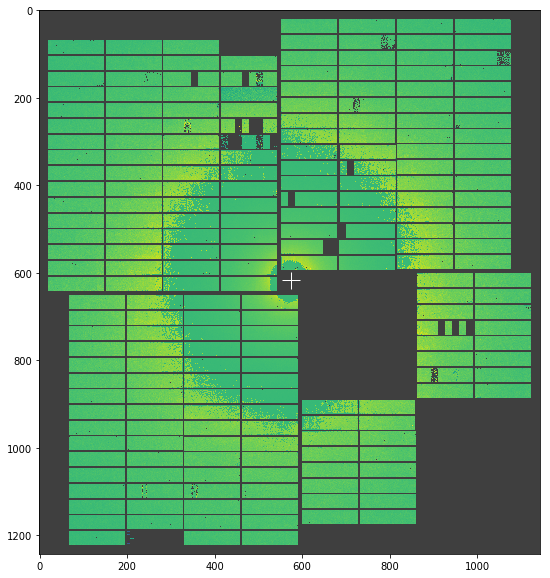

In [12]:
geom.plot_data(clip(modules_data[12], max=5000))

Reassemble detector data into a numpy array for further analysis. The areas without data have the special value *`nan`* to mark them as missing.

(128, 1243, 1145)


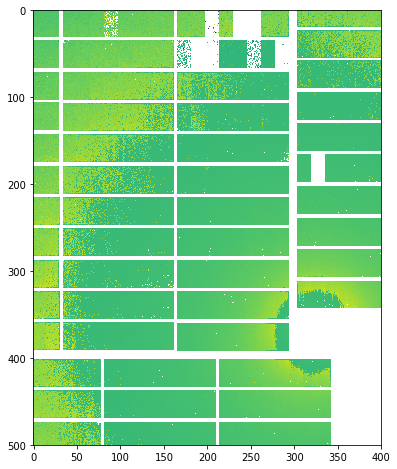

In [13]:
res, centre = geom.position_all_modules(modules_data)
print(res.shape)
plt.figure(figsize=(8, 8))
plt.imshow(clip(res[12, 250:750, 250:650], max=5000))